# Objective
Forecast sales (no. of items sold) for each item and store for the next 28 days

20200527: Diff from m5-forecasting_v1.ipynb: Here we do predictions for 1 state at a time

20200608: Diff from m5-forecasting_v2.ipynb: Here we do hyperparam tuning

20200619: Diff from m5-forecasting_v5.ipynb: Here we create the submission file for evaluation.

20200625: Diff from m5-forecasting_v5.ipynb: Here we use only last 1 years of data for training

In [620]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import gc
import matplotlib
import numpy as np # linear algebra
import operator as op
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import time

from collections import OrderedDict
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor

%matplotlib inline

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [621]:
##### Input params ########
state = 'WI'
store = 'WI_3' # CA_1, CA_2, CA_3, CA_4, TX_1, TX_2, TX_3, WI_1, WI_2, WI_3

model_seed = 102
sample_seed = 103              # for sampling the dataframe

n_estimators = 100             # for the initial model before tuning. default = 100
max_depth = 3                  # for the initial model before tuning. default = 3
learning_rate = 0.1            # for the initial model before tuning. default = 0.1
min_child_weight = 1           # for the initial model before tuning. default = 1
subsample = 1                  # for the initial model before tuning. default = 1
colsample_bytree = 1           # for the initial model before tuning. default = 1
colsample_bylevel = 1          # for the initial model before tuning. default = 1
train_test_split_seed = 111    # 111
model_seed = 100

# train_start = 0
# train_end = 1884               # use date_block_num from train_start to train_end as train set
# val_date_block_num = 1885      # date_block_num for validation set
# pred_start = 1886              # do pred starting from this day
# pred_end = 1913                # do pred until and include this day

train_start = 1912 - 1*365
train_end = 1912               # use date_block_num from train_start to train_end as train set
val_date_block_num = 1913      # date_block_num for validation set
pred_start = 1914            # do pred starting from this day
pred_end = 1941              # do pred until and include this day

# train_start = 0
# train_end = 1940               # use date_block_num from train_start to train_end as train set
# val_date_block_num = 1941      # date_block_num for validation set
# pred_start = 1942            # do pred starting from this day
# pred_end = 1969              # do pred until and include this day

shift_range = [1, 2, 3, 4, 5, 6, 7, 30, 365] # Use values from last 7 days, from 30 days ago, and from 365 days ago

fontsize = 14
ticklabelsize = 14
###########################

In [622]:
train_start

1547

In [623]:
ticStart = time.time()

# Common functions

In [624]:
def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int16`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int16)
    
    return df

def get_lags(index_cols, cols_to_rename, all_data, shift_range):
    """
    For a dataframe all_data, get the lags specified in cols_to_rename
    Input
        index_cols    : e.g. ['item_id', 'store_id', 'date_block_num']. These are the cols to do merging with the
                        lagged dataset
        cols_to_rename: e.g. ['target']. Based on this example, all_data will be returned with columns target_lag_1, 
                        target_lag_2, ..., target_lag_365.
        all_data      : need to have a column 'date_block_num' to indicate chronological order
        shift_range   : e.g. [1, 2, 3, 4, 5, 6, 7, 30, 365]
    Output
        all_data
    """
    for day_shift in shift_range:
        train_shift = all_data[index_cols + cols_to_rename].copy()
    
        # E.g. variable of 0 becomes 1, for day_shift = 1.
        # So when this is merged with variable of 1 in all_data, this will represent lag of 1.
        train_shift['date_block_num'] = train_shift['date_block_num'] + day_shift
    
        foo = lambda x: '{}_lag_{}'.format(x, day_shift) if x in cols_to_rename else x
        train_shift = train_shift.rename(columns=foo)

        all_data = pd.merge(all_data, train_shift, on=index_cols, how='left')
    
        # Fill the NaNs with 0
        for x in cols_to_rename:
            all_data[x + '_lag_' + str(day_shift)].fillna(0, inplace=True)
    
    del train_shift
    gc.collect();

    return all_data


# Load data

In [625]:
sell_prices = pd.read_csv("./data/sell_prices.csv")
sell_prices.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


File 2: “sell_prices.csv”

Contains information about the price of the products sold per store and date.
* store_id: The id of the store where the product is sold. 
* item_id: The id of the product.
* wm_yr_wk: The id of the week.
* sell_price: The price of the product for the given week/store. The price is provided per week (average across seven days). If not available, this means that the product was not sold during the examined week. Note that although prices are constant at weekly basis, they may change through time (both training and test set).

In [626]:
calendar = pd.read_csv("./data/calendar.csv")
calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


File 1: “calendar.csv” 

Contains information about the dates the products are sold.
* date: The date in a “y-m-d” format.
* wm_yr_wk: The id of the week the date belongs to.
* weekday: The type of the day (Saturday, Sunday, …, Friday).
* wday: The id of the weekday, starting from Saturday.
* month: The month of the date.
* year: The year of the date.
* event_name_1: If the date includes an event, the name of this event.
* event_type_1: If the date includes an event, the type of this event.
* event_name_2: If the date includes a second event, the name of this event.
* event_type_2: If the date includes a second event, the type of this event.
* snap_CA, snap_TX, and snap_WI: A binary variable (0 or 1) indicating whether the stores of CA, TX or WI allow SNAP purchases on the examined date. 1 indicates that SNAP purchases are allowed.


In [627]:
sales_tr_val = pd.read_csv("./data/sales_train_validation.csv")
print("len(sales_tr_val) = " + str(len(sales_tr_val)))
sales_tr_val.head()

len(sales_tr_val) = 30490


,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


For each (item_id, store_id), we have the number of items sold for 1913 days or 5.24 years.

There are 30,490 distinct id's, and 1913 days which gives 30,490*1913 = 58,327,370

In [628]:
# Keep only data from one state
sales_tr_eval = sales_tr_val[(sales_tr_val['state_id']==state) & (sales_tr_val['store_id']==store)]
print("len(sales_tr_val) = " + str(len(sales_tr_val)))

len(sales_tr_val) = 30490


In [629]:
# sales_tr_eval = pd.read_csv("./data/sales_train_evaluation.csv")
# print("len(sales_tr_eval) = " + str(len(sales_tr_eval)))
# sales_tr_eval.head()

For each (item_id, store_id), we have the number of items sold for 1941 days or 5.32 years.

In [630]:
# # Keep only data from one state
# sales_tr_eval = sales_tr_eval[(sales_tr_eval['state_id']==state) & (sales_tr_eval['store_id']==store)]
# print("len(sales_tr_eval) = " + str(len(sales_tr_eval)))

In [631]:
sample_sub = pd.read_csv("./data/sample_submission.csv")
print(len(sample_sub))
sample_sub.head()

60980


,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,HOBBIES_1_002_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,HOBBIES_1_004_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,HOBBIES_1_005_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Provide the forecast for each id for the next 28 days. For the validation rows, this corresponds to d_1914 - d_1941, and for the evaluation rows, this corresponds to d_1942 - d_1969. (Note: a month before the competition close, the ground truth for the validation rows will be provided.)

Note 30,490*2 = 60,980 which is the number of rows in the submission file.

# Pre-process data

In [632]:
print(calendar.memory_usage().sum())

# # In calendar 'd' column, change 'd_1' to 1
# calendar['d'] = calendar.apply(lambda row: row['d'].split('_')[1], axis=1)

# Replance NaN with nil
calendar = calendar.fillna(value = 'nil')

# Downcast dtypes from 64 bit to save memory
calendar= downcast_dtypes(calendar)

# Change to category dtype
calendar[["year", "event_name_1", "event_type_1", "event_name_2", "event_type_2"]] = \
    calendar[["year", "event_name_1", "event_type_1", "event_name_2", "event_type_2"]] .astype("category")

# Drop weekday column since its not used
calendar.drop(['weekday'], axis=1, inplace=True)

print(calendar.memory_usage().sum())

calendar.head()

220608
67297


,date,wm_yr_wk,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,1,1,2011,d_1,nil,nil,nil,nil,0,0,0
1,2011-01-30,11101,2,1,2011,d_2,nil,nil,nil,nil,0,0,0
2,2011-01-31,11101,3,1,2011,d_3,nil,nil,nil,nil,0,0,0
3,2011-02-01,11101,4,2,2011,d_4,nil,nil,nil,nil,1,1,0
4,2011-02-02,11101,5,2,2011,d_5,nil,nil,nil,nil,1,0,1


In [633]:
# Downcast dtypes from 64 bit to save memory
print(sell_prices.memory_usage().sum())
sell_prices = downcast_dtypes(sell_prices)

sell_prices[["store_id", "item_id"]] = \
    sell_prices[["store_id","item_id"]].astype("category")

print(sell_prices.memory_usage().sum())

218915952
61676881


In [634]:
# Downcast dtypes from 64 bit to save memory
print(sales_tr_eval.memory_usage().sum())
sales_tr_eval = downcast_dtypes(sales_tr_eval)

sales_tr_eval[["item_id", "dept_id", "cat_id", "store_id", "state_id"]] = \
    sales_tr_eval[["item_id", "dept_id", "cat_id", "store_id", "state_id"]].astype("category")

print(sales_tr_eval.memory_usage().sum())

46832640


/Users/yibin/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


11839520


In [635]:
# Melt sales_tr_eval to switch from a wide to a long dataframe
tic = time.time()
value_vars = ['d_' + str(x) for x in range(1, 1914)]
sale_tr_val_melt = pd.melt(sales_tr_eval, 
                           id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], 
                           value_vars=value_vars)

toc = time.time()
print("Time taken = " + str(toc-tic) + ' s')
sale_tr_val_melt.head()

Time taken = 11.595896005630493 s


,id,item_id,dept_id,cat_id,store_id,state_id,variable,value
0,HOBBIES_1_001_WI_3_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,WI_3,WI,d_1,0
1,HOBBIES_1_002_WI_3_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,WI_3,WI,d_1,0
2,HOBBIES_1_003_WI_3_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,WI_3,WI,d_1,0
3,HOBBIES_1_004_WI_3_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,WI_3,WI,d_1,4
4,HOBBIES_1_005_WI_3_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,WI_3,WI,d_1,0


In [636]:
del sales_tr_eval
gc.collect();
sales_tr_eval = pd.DataFrame()

In [637]:
# Merge with calendar to get events info
sale_tr_val_melt_merged = sale_tr_val_melt.merge(calendar, 
                                                 left_on='variable', 
                                                 right_on='d', 
                                                 how='left')

# Drop unneccesary columns
sale_tr_val_melt_merged.drop(columns=['d'], inplace=True)

sale_tr_val_melt_merged.head()

,id,item_id,dept_id,cat_id,store_id,state_id,variable,value,date,wm_yr_wk,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,HOBBIES_1_001_WI_3_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,WI_3,WI,d_1,0,2011-01-29,11101,1,1,2011,nil,nil,nil,nil,0,0,0
1,HOBBIES_1_002_WI_3_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,WI_3,WI,d_1,0,2011-01-29,11101,1,1,2011,nil,nil,nil,nil,0,0,0
2,HOBBIES_1_003_WI_3_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,WI_3,WI,d_1,0,2011-01-29,11101,1,1,2011,nil,nil,nil,nil,0,0,0
3,HOBBIES_1_004_WI_3_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,WI_3,WI,d_1,4,2011-01-29,11101,1,1,2011,nil,nil,nil,nil,0,0,0
4,HOBBIES_1_005_WI_3_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,WI_3,WI,d_1,0,2011-01-29,11101,1,1,2011,nil,nil,nil,nil,0,0,0


In [638]:
# Merge with sell_prices to get price info
sale_tr_val_melt_merged2 = sale_tr_val_melt_merged.merge(sell_prices, 
                                                         left_on=['store_id', 'item_id', 'wm_yr_wk'], 
                                                         right_on=['store_id', 'item_id', 'wm_yr_wk'], 
                                                         how='left')
sale_tr_val_melt_merged2.head()

,id,item_id,dept_id,cat_id,store_id,state_id,variable,value,date,wm_yr_wk,...,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_001_WI_3_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,WI_3,WI,d_1,0,2011-01-29,11101,...,1,2011,nil,nil,nil,nil,0,0,0,NaN
1,HOBBIES_1_002_WI_3_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,WI_3,WI,d_1,0,2011-01-29,11101,...,1,2011,nil,nil,nil,nil,0,0,0,NaN
2,HOBBIES_1_003_WI_3_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,WI_3,WI,d_1,0,2011-01-29,11101,...,1,2011,nil,nil,nil,nil,0,0,0,NaN
3,HOBBIES_1_004_WI_3_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,WI_3,WI,d_1,4,2011-01-29,11101,...,1,2011,nil,nil,nil,nil,0,0,0,4.34
4,HOBBIES_1_005_WI_3_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,WI_3,WI,d_1,0,2011-01-29,11101,...,1,2011,nil,nil,nil,nil,0,0,0,NaN


In [639]:
# del sell_prices
# gc.collect();
# sell_prices = pd.DataFrame()

del sale_tr_val_melt_merged
gc.collect();
sale_tr_val_melt_merged = pd.DataFrame()

In [640]:
# Get no. of distinct values in each column
print("item_id uniques = " + str(sale_tr_val_melt_merged2['item_id'].nunique()))
print("dept_id uniques = " + str(sale_tr_val_melt_merged2['dept_id'].nunique()))
print("cat_id uniques = " + str(sale_tr_val_melt_merged2['cat_id'].nunique()))
print("store_id uniques = " + str(sale_tr_val_melt_merged2['store_id'].nunique()))
print("state_id uniques = " + str(sale_tr_val_melt_merged2['state_id'].nunique()))

item_id uniques = 3049
dept_id uniques = 7
cat_id uniques = 3
store_id uniques = 1
state_id uniques = 1


In [641]:
print(sale_tr_val_melt_merged2['dept_id'].unique())

[HOBBIES_1, HOBBIES_2, HOUSEHOLD_1, HOUSEHOLD_2, FOODS_1, FOODS_2, FOODS_3]
Categories (7, object): [HOBBIES_1, HOBBIES_2, HOUSEHOLD_1, HOUSEHOLD_2, FOODS_1, FOODS_2, FOODS_3]


In [642]:
print(sale_tr_val_melt_merged2['cat_id'].unique())

[HOBBIES, HOUSEHOLD, FOODS]
Categories (3, object): [HOBBIES, HOUSEHOLD, FOODS]


In [643]:
print(sale_tr_val_melt_merged2['store_id'].unique())

['WI_3']


In [644]:
print(sale_tr_val_melt_merged2['state_id'].unique())

[WI]
Categories (1, object): [WI]


In [645]:
# Convert variable to a numerical column ie. d_1 to 1
sale_tr_val_melt_merged2['variable'] = sale_tr_val_melt_merged2['variable'].str.split('_').str[1]
sale_tr_val_melt_merged2

,id,item_id,dept_id,cat_id,store_id,state_id,variable,value,date,wm_yr_wk,...,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_001_WI_3_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,WI_3,WI,1,0,2011-01-29,11101,...,1,2011,nil,nil,nil,nil,0,0,0,NaN
1,HOBBIES_1_002_WI_3_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,WI_3,WI,1,0,2011-01-29,11101,...,1,2011,nil,nil,nil,nil,0,0,0,NaN
2,HOBBIES_1_003_WI_3_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,WI_3,WI,1,0,2011-01-29,11101,...,1,2011,nil,nil,nil,nil,0,0,0,NaN
3,HOBBIES_1_004_WI_3_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,WI_3,WI,1,4,2011-01-29,11101,...,1,2011,nil,nil,nil,nil,0,0,0,4.34
4,HOBBIES_1_005_WI_3_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,WI_3,WI,1,0,2011-01-29,11101,...,1,2011,nil,nil,nil,nil,0,0,0,NaN
5,HOBBIES_1_006_WI_3_validation,HOBBIES_1_006,HOBBIES_1,HOBBIES,WI_3,WI,1,0,2011-01-29,11101,...,1,2011,nil,nil,nil,nil,0,0,0,NaN
6,HOBBIES_1_007_WI_3_validation,HOBBIES_1_007,HOBBIES_1,HOBBIES,WI_3,WI,1,0,2011-01-29,11101,...,1,2011,nil,nil,nil,nil,0,0,0,NaN
7,HOBBIES_1_008_WI_3_validation,HOBBIES_1_008,HOBBIES_1,HOBBIES,WI_3,WI,1,6,2011-01-29,11101,...,1,2011,nil,nil,nil,nil,0,0,0,0.46
8,HOBBIES_1_009_WI_3_validation,HOBBIES_1_009,HOBBIES_1,HOBBIES,WI_3,WI,1,1,2011-01-29,11101,...,1,2011,nil,nil,nil,nil,0,0,0,1.56
9,HOBBIES_1_010_WI_3_validation,HOBBIES_1_010,HOBBIES_1,HOBBIES,WI_3,WI,1,0,2011-01-29,11101,...,1,2011,nil,nil,nil,nil,0,0,0,3.17


In [646]:
# Convert variable to int
sale_tr_val_melt_merged2['variable'] = sale_tr_val_melt_merged2['variable'].astype('int16')

# Create features

In [647]:
all_data = sale_tr_val_melt_merged2
all_data = all_data.rename(columns={'variable': 'date_block_num', 
                                    'value': 'target'})

In [648]:
# Remove unnecessaray column
all_data.drop(['date'], axis=1, inplace=True)

In [649]:
# Convert features to categorical
columns_to_be_labeled = [
    'year',
    'event_name_1',
    'event_type_1',
    'event_name_2',
    'event_type_2',
    'wm_yr_wk',
    'item_id',
    'store_id',
    'dept_id',
    'cat_id',
    'state_id'
]
for column in columns_to_be_labeled:
    all_data.loc[:, column] = LabelEncoder().fit_transform(all_data[column]) # fit_transform: Fit label encoder and return encoded labels. Note the encoded labels are integers!!

all_data.head()

,id,item_id,dept_id,cat_id,store_id,state_id,date_block_num,target,wm_yr_wk,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_001_WI_3_validation,1437,3,1,0,0,1,0,0,1,1,0,30,4,4,2,0,0,0,NaN
1,HOBBIES_1_002_WI_3_validation,1438,3,1,0,0,1,0,0,1,1,0,30,4,4,2,0,0,0,NaN
2,HOBBIES_1_003_WI_3_validation,1439,3,1,0,0,1,0,0,1,1,0,30,4,4,2,0,0,0,NaN
3,HOBBIES_1_004_WI_3_validation,1440,3,1,0,0,1,4,0,1,1,0,30,4,4,2,0,0,0,4.34
4,HOBBIES_1_005_WI_3_validation,1441,3,1,0,0,1,0,0,1,1,0,30,4,4,2,0,0,0,NaN


In [650]:
index_cols = ['item_id', 'store_id', 'date_block_num']

cols_to_rename = ['target']

for day_shift in shift_range:
    print(day_shift)
    train_shift = all_data[index_cols + cols_to_rename].copy()
    
    # E.g. variable of 0 becomes 1, for day_shift = 1.
    # So when this is merged with variable of 1 in all_data, this will represent lag of 1.
    train_shift['date_block_num'] = train_shift['date_block_num'] + day_shift
    
    foo = lambda x: '{}_lag_{}'.format(x, day_shift) if x in cols_to_rename else x
    train_shift = train_shift.rename(columns=foo)

    all_data = pd.merge(all_data, train_shift, on=index_cols, how='left')
    
    # Fill the NaNs with 0
    for x in cols_to_rename:
        all_data[x + '_lag_' + str(day_shift)].fillna(0, inplace=True)
    
del train_shift
gc.collect();

all_data

1
2
3
4
5
6
7
30
365


,id,item_id,dept_id,cat_id,store_id,state_id,date_block_num,target,wm_yr_wk,wday,...,sell_price,target_lag_1,target_lag_2,target_lag_3,target_lag_4,target_lag_5,target_lag_6,target_lag_7,target_lag_30,target_lag_365
0,HOBBIES_1_001_WI_3_validation,1437,3,1,0,0,1,0,0,1,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,HOBBIES_1_002_WI_3_validation,1438,3,1,0,0,1,0,0,1,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,HOBBIES_1_003_WI_3_validation,1439,3,1,0,0,1,0,0,1,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,HOBBIES_1_004_WI_3_validation,1440,3,1,0,0,1,4,0,1,...,4.34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,HOBBIES_1_005_WI_3_validation,1441,3,1,0,0,1,0,0,1,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,HOBBIES_1_006_WI_3_validation,1442,3,1,0,0,1,0,0,1,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,HOBBIES_1_007_WI_3_validation,1443,3,1,0,0,1,0,0,1,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,HOBBIES_1_008_WI_3_validation,1444,3,1,0,0,1,6,0,1,...,0.46,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,HOBBIES_1_009_WI_3_validation,1445,3,1,0,0,1,1,0,1,...,1.56,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,HOBBIES_1_010_WI_3_validation,1446,3,1,0,0,1,0,0,1,...,3.17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [651]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5832737 entries, 0 to 5832736
Data columns (total 29 columns):
id                object
item_id           int64
dept_id           int64
cat_id            int64
store_id          int64
state_id          int64
date_block_num    int16
target            int16
wm_yr_wk          int64
wday              int16
month             int16
year              int64
event_name_1      int64
event_type_1      int64
event_name_2      int64
event_type_2      int64
snap_CA           int16
snap_TX           int16
snap_WI           int16
sell_price        float32
target_lag_1      float64
target_lag_2      float64
target_lag_3      float64
target_lag_4      float64
target_lag_5      float64
target_lag_6      float64
target_lag_7      float64
target_lag_30     float64
target_lag_365    float64
dtypes: float32(1), float64(9), int16(7), int64(11), object(1)
memory usage: 1.1+ GB


# Split into train, val, test sets

We use 30 days as validation data

In [652]:
to_drop_cols = ['id', 'target', 'date_block_num']

In [653]:
X_train = all_data[(all_data['date_block_num']>=train_start) & 
                   (all_data['date_block_num']<=train_end)].drop(to_drop_cols, axis = 1)
X_cv = all_data[all_data['date_block_num']==val_date_block_num].drop(to_drop_cols, axis = 1)
X_train_cv = all_data[(all_data['date_block_num']>=train_start) & 
                      (all_data['date_block_num']<=val_date_block_num)].drop(to_drop_cols, axis = 1)

y_train = all_data[(all_data['date_block_num']>=train_start) & 
                   (all_data['date_block_num']<=train_end)][['id', 'target']]
y_cv = all_data[all_data['date_block_num']==val_date_block_num][['id', 'target']]
y_train_cv = all_data[(all_data['date_block_num']>=train_start) &
                      (all_data['date_block_num']<=val_date_block_num)][['id', 'target']]

# Train the model and get prediction for day val_date_block_num

In [654]:
# Create the model
model = XGBRegressor(seed=model_seed,
                      n_estimators=n_estimators,
                      max_depth=max_depth,
                      learning_rate=learning_rate,
                      min_child_weight=min_child_weight)

# Train the regressor
model.fit(X_train, y_train['target'])

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=100, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=100, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [655]:
# View a list of the features and their importance scores
imp = list(zip(X_train.columns, model.feature_importances_))
imp.sort(key=lambda tup: tup[1], reverse=False) 
imp

[('dept_id', 0.0),
 ('cat_id', 0.0),
 ('store_id', 0.0),
 ('state_id', 0.0),
 ('year', 0.0),
 ('event_name_2', 0.0),
 ('event_type_2', 0.0),
 ('snap_TX', 0.0),
 ('wm_yr_wk', 0.0018404159),
 ('month', 0.0032625413),
 ('event_type_1', 0.0033236074),
 ('snap_CA', 0.0035191244),
 ('event_name_1', 0.005541359),
 ('sell_price', 0.0056023807),
 ('snap_WI', 0.0064739934),
 ('wday', 0.008831095),
 ('item_id', 0.009521296),
 ('target_lag_30', 0.024524856),
 ('target_lag_365', 0.030306213),
 ('target_lag_5', 0.04428626),
 ('target_lag_4', 0.053701147),
 ('target_lag_6', 0.09176658),
 ('target_lag_7', 0.12020173),
 ('target_lag_2', 0.12760726),
 ('target_lag_3', 0.18219058),
 ('target_lag_1', 0.27749953)]

In [656]:
# Do prediction on train set
pred = model.predict(X_train).astype('int')

# Calculate RMSE
print("Train set MSE = " + str(mean_squared_error(y_train['target'], pred)))

# Do prediction on val set
pred = model.predict(X_cv).astype('int')

# Calculate RMSE
print("Val set MSE = " + str(mean_squared_error(y_cv['target'], pred)))

Train set MSE = 3.6155399871318554
Val set MSE = 3.3932436864545754


In [657]:
y_cv['pred'] = pred
y_cv

,id,target,pred
5829688,HOBBIES_1_001_WI_3_validation,0,0
5829689,HOBBIES_1_002_WI_3_validation,0,0
5829690,HOBBIES_1_003_WI_3_validation,1,0
5829691,HOBBIES_1_004_WI_3_validation,2,0
5829692,HOBBIES_1_005_WI_3_validation,0,0
5829693,HOBBIES_1_006_WI_3_validation,2,0
5829694,HOBBIES_1_007_WI_3_validation,0,0
5829695,HOBBIES_1_008_WI_3_validation,3,1
5829696,HOBBIES_1_009_WI_3_validation,0,0
5829697,HOBBIES_1_010_WI_3_validation,0,0


# Hyperparameter tuning

## Plot the error rate versus n_estimators, varying max_depth (size of tree, default = 3)

In [658]:
ensemble_clfs = [
    (3,
        XGBRegressor(seed=model_seed,
                      max_depth=3,
                      learning_rate=learning_rate,
                      min_child_weight=min_child_weight)),
    (5,
        XGBRegressor(seed=model_seed,
                      max_depth=5,
                      learning_rate=learning_rate,
                      min_child_weight=min_child_weight)),
    (7,
        XGBRegressor(seed=model_seed,
                      max_depth=7,
                      learning_rate=learning_rate,
                      min_child_weight=min_child_weight)),
    (9,
        XGBRegressor(seed=model_seed,
                      max_depth=9,
                      learning_rate=learning_rate,
                      min_child_weight=min_child_weight))
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
estimators_list = [10]
estimators_list.extend(range(100, 500, 200))

tic = time.time()
for label, clf in ensemble_clfs:
    print(label)
    for i in estimators_list:
        print(i)
        tic1 = time.time()
        clf.set_params(n_estimators=i)
        clf.fit(X_train, y_train['target'])
        
        pred = clf.predict(X_cv).astype('int')
        error_rate[label].append((i, mean_squared_error(y_cv['target'], pred)))
        toc1 = time.time()
        print("Time taken = " + str((toc1-tic1)/60.0) + " mins")
        
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))

3
10
Time taken = 0.08027561902999877 mins
100
Time taken = 0.6253700335820516 mins
300
Time taken = 1.7471144994099934 mins
5
10
Time taken = 0.1205800493558248 mins
100
Time taken = 0.9501537839571635 mins
300
Time taken = 2.829569717248281 mins
7
10
Time taken = 0.15904171466827394 mins
100
Time taken = 1.3753807346026103 mins
300
Time taken = 4.067907400925955 mins
9
10
Time taken = 0.2056635856628418 mins
100
Time taken = 1.7656787673632304 mins
300
Time taken = 5.286937201023102 mins
Minutes taken = 19.21534366607666


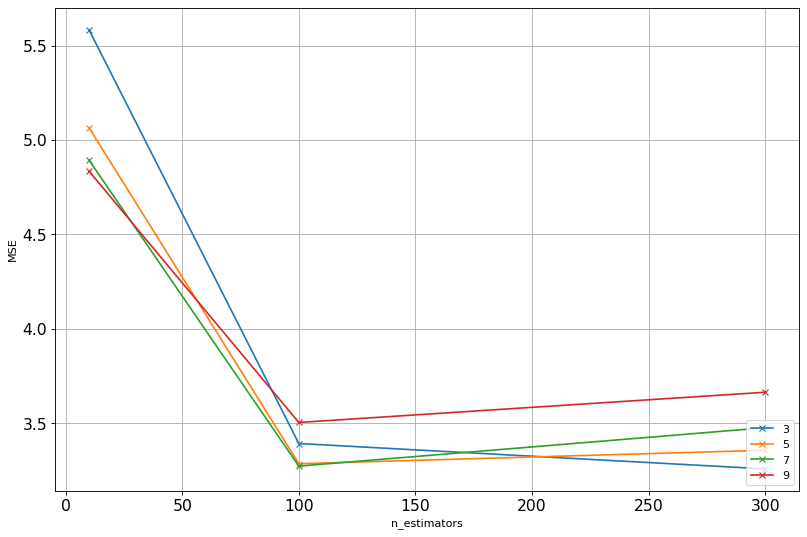

In [659]:
# Generate the "error rate" vs. "n_estimators" plot.
plt.figure(figsize=(12, 8), dpi=80)
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label, marker='x')

plt.xlabel("n_estimators")
plt.ylabel("MSE")
plt.legend(loc="lower right")
plt.grid()
matplotlib.rcParams.update({'font.size': fontsize})
matplotlib.rcParams['xtick.labelsize'] = ticklabelsize
matplotlib.rcParams['ytick.labelsize'] = ticklabelsize

In [660]:
error_rate

OrderedDict([(3,
              [(10, 5.584781895703509),
               (100, 3.3932436864545754),
               (300, 3.258773368317481)]),
             (5,
              [(10, 5.066251229911447),
               (100, 3.2863233847163005),
               (300, 3.35749426041325)]),
             (7,
              [(10, 4.894391603804526),
               (100, 3.2735323056739913),
               (300, 3.476877664808134)]),
             (9,
              [(10, 4.836011807149885),
               (100, 3.5047556575926535),
               (300, 3.664808133814365)])])

In [661]:
def get_params(error_rate):
    metric1_opt = list(error_rate.items())[0][0]
    metric2_opt = list(error_rate.items())[0][1][0][0]
    mse_min = list(error_rate.items())[0][1][0][1]
    for item in error_rate:
        metric2, mse = min(error_rate[item], key=op.itemgetter(1))
        if mse < mse_min:
            metric1_opt = item
            metric2_opt = metric2
            mse_min = mse

    return (metric1_opt, metric2_opt, mse_min)

max_depth_opt, n_estimators_opt, mse_min = get_params(error_rate)
max_depth_opt, n_estimators_opt, mse_min

(3, 300, 3.258773368317481)

## Plot the error rate versus n_estimators, varying learning_rate (default = 0.1)

In [662]:
ensemble_clfs = [
    (0.1,
        XGBRegressor(seed=model_seed,
                      max_depth=max_depth_opt,
                      learning_rate=0.1,
                      min_child_weight=min_child_weight)),
    (0.01,
        XGBRegressor(seed=model_seed,
                      max_depth=max_depth_opt,
                      learning_rate=0.01,
                      min_child_weight=min_child_weight)),
    (0.001,
        XGBRegressor(seed=model_seed,
                      max_depth=max_depth_opt,
                      learning_rate=0.001,
                      min_child_weight=min_child_weight))
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
estimators_list = [10]
estimators_list.extend(range(100, 500, 200))

tic = time.time()
for label, clf in ensemble_clfs:
    print(label)
    for i in estimators_list:
        print(i)
        tic1 = time.time()
        clf.set_params(n_estimators=i)
        clf.fit(X_train, y_train['target'])
        
        pred = clf.predict(X_cv).astype('int')
        error_rate[label].append((i, mean_squared_error(y_cv['target'], pred)))
        toc1 = time.time()
        print("Time taken = " + str((toc1-tic1)/60.0) + " mins")

toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))

0.1
10
Time taken = 0.07787603537241618 mins
100
Time taken = 0.6017421007156372 mins
300
Time taken = 1.808631134033203 mins
0.01
10
Time taken = 0.07840426762898763 mins
100
Time taken = 0.599614417552948 mins
300
Time taken = 1.7672380328178405 mins
0.001
10
Time taken = 0.0820761481920878 mins
100
Time taken = 0.6139594197273255 mins
300
Time taken = 1.8063268502553305 mins
Minutes taken = 7.436079915364584


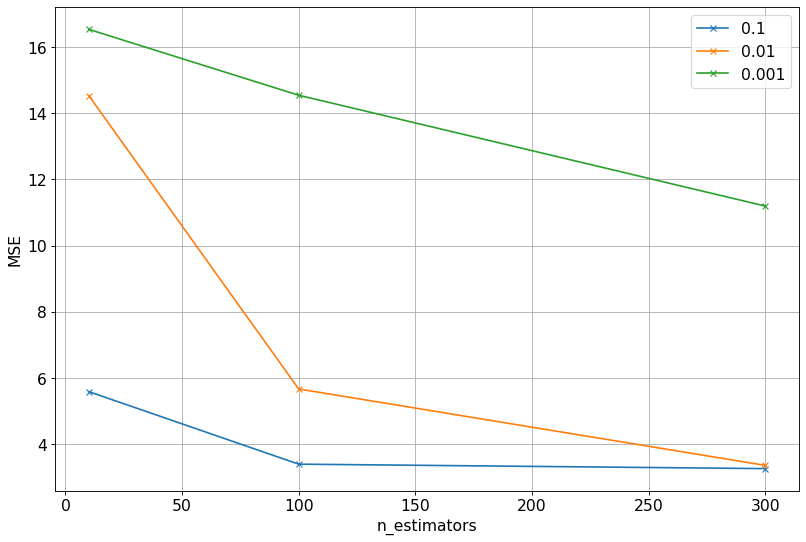

In [663]:
# Generate the "error rate" vs. "n_estimators" plot.
plt.figure(figsize=(12, 8), dpi=80)
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label, marker='x')

plt.xlabel("n_estimators")
plt.ylabel("MSE")
plt.legend(loc="upper right")
plt.grid()
matplotlib.rcParams.update({'font.size': fontsize})
matplotlib.rcParams['xtick.labelsize'] = ticklabelsize
matplotlib.rcParams['ytick.labelsize'] = ticklabelsize

In [664]:
error_rate

OrderedDict([(0.1,
              [(10, 5.584781895703509),
               (100, 3.3932436864545754),
               (300, 3.258773368317481)]),
             (0.01,
              [(10, 14.52902591013447),
               (100, 5.664480157428665),
               (300, 3.35683830764185)]),
             (0.001,
              [(10, 16.531321744834372),
               (100, 14.540177107248278),
               (300, 11.192850114791735)])])

In [665]:
learning_rate_opt, n_estimators_opt, mse_min = get_params(error_rate)
learning_rate_opt, n_estimators_opt, mse_min

(0.1, 300, 3.258773368317481)

## Plot the error rate versus n_estimators, varying min_child_weight (default = 1)

In [666]:
ensemble_clfs = [
    (1,
        XGBRegressor(seed=model_seed,
                      max_depth=max_depth_opt,
                      learning_rate=learning_rate_opt,
                      min_child_weight=1)),
    (10,
        XGBRegressor(seed=model_seed,
                      max_depth=max_depth_opt,
                      learning_rate=learning_rate_opt,
                      min_child_weight=10)),
     (50,
        XGBRegressor(seed=model_seed,
                      max_depth=max_depth_opt,
                      learning_rate=learning_rate_opt,
                      min_child_weight=10)),
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
estimators_list = [10]
estimators_list.extend(range(100, 400, 200))

tic = time.time()
for label, clf in ensemble_clfs:
    print(label)
    for i in estimators_list:
        print(i)
        tic1 = time.time()
        clf.set_params(n_estimators=i)
        clf.fit(X_train, y_train['target'])
        
        pred = clf.predict(X_cv).astype('int')
        error_rate[label].append((i, mean_squared_error(y_cv['target'], pred)))
        toc1 = time.time()
        print("Time taken = " + str((toc1-tic1)/60.0) + " mins")

toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))

1
10
Time taken = 0.07863930066426596 mins
100
Time taken = 0.6260475715001425 mins
300
Time taken = 1.750343962510427 mins
10
10
Time taken = 0.0784719189008077 mins
100
Time taken = 0.5920904994010925 mins
300
Time taken = 1.7631216843922932 mins
50
10
Time taken = 0.09044518073399861 mins
100
Time taken = 0.6203950802485149 mins
300
Time taken = 1.7431806842486064 mins
Minutes taken = 7.3428028464317325


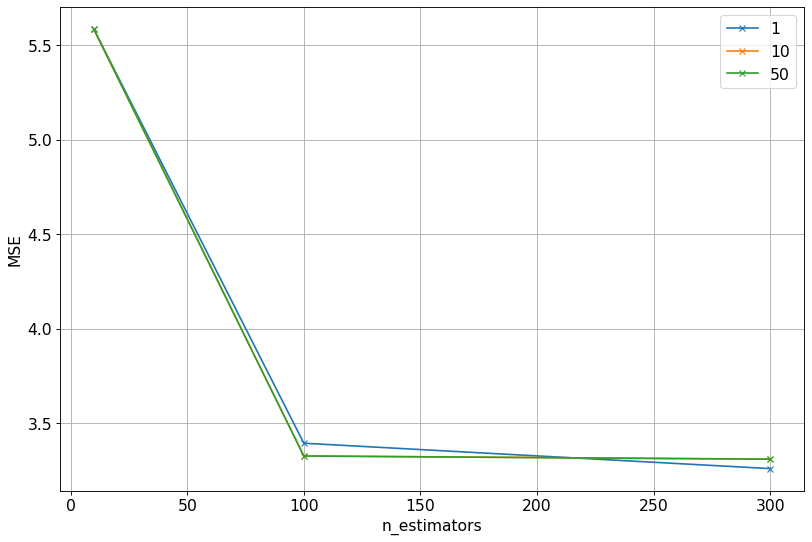

In [667]:
# Generate the "error rate" vs. "n_estimators" plot.
plt.figure(figsize=(12, 8), dpi=80)
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label, marker='x')

plt.xlabel("n_estimators")
plt.ylabel("MSE")
plt.legend(loc="upper right")
plt.grid()
matplotlib.rcParams.update({'font.size': fontsize})
matplotlib.rcParams['xtick.labelsize'] = ticklabelsize
matplotlib.rcParams['ytick.labelsize'] = ticklabelsize

In [668]:
error_rate

OrderedDict([(1,
              [(10, 5.584781895703509),
               (100, 3.3932436864545754),
               (300, 3.258773368317481)]),
             (10,
              [(10, 5.584781895703509),
               (100, 3.325680551000328),
               (300, 3.308625778943916)]),
             (50,
              [(10, 5.584781895703509),
               (100, 3.325680551000328),
               (300, 3.308625778943916)])])

In [669]:
min_child_weight_opt, n_estimators_opt, mse_min = get_params(error_rate)
min_child_weight_opt, n_estimators_opt, mse_min

(1, 300, 3.258773368317481)

In [670]:
# n_estimators_opt = 300
# max_depth_opt = 9
# learning_rate_opt = 0.1
# min_child_weight_opt = 1

# Retrain model with optimum hyperparameters

In [671]:
# Create the model
model = XGBRegressor(seed=model_seed,
                      n_estimators=n_estimators_opt,
                      max_depth=max_depth_opt,
                      learning_rate=learning_rate_opt,
                      min_child_weight=min_child_weight_opt)

# # Train the regressor
# model.fit(X_train, y_train['target'])

# # Do prediction on train set
# pred = model.predict(X_train).astype('int')

# # Calculate RMSE
# print("Train set MSE = " + str(mean_squared_error(y_train['target'], pred)))

# # Do prediction on val set
# pred = model.predict(X_cv).astype('int')

# # Calculate RMSE
# print("Val set MSE = " + str(mean_squared_error(y_cv['target'], pred)))

By tuning hyperparams, MSE of the val set dropped from 6.89 to 6.57

# Retrain model on train+val set

In [672]:
# Train the regressor
model.fit(X_train_cv, y_train_cv['target'])

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=300, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=100, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=100, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

# Get predictions for evaluation set 28 days

In [673]:
# Rename columns
sale_tr_val_melt = sale_tr_val_melt.rename(columns={'variable': 'date_block_num', 
                                                    'value': 'target'})

In [674]:
# Convert variable to a numerical column ie. d_1 to 1
sale_tr_val_melt['date_block_num'] = sale_tr_val_melt['date_block_num'].str.split('_').str[1].astype('int16')
sale_tr_val_melt.tail()

,id,item_id,dept_id,cat_id,store_id,state_id,date_block_num,target
5832732,FOODS_3_823_WI_3_validation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,1913,1
5832733,FOODS_3_824_WI_3_validation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,1913,0
5832734,FOODS_3_825_WI_3_validation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,1913,0
5832735,FOODS_3_826_WI_3_validation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,1913,3
5832736,FOODS_3_827_WI_3_validation,FOODS_3_827,FOODS_3,FOODS,WI_3,WI,1913,0


In [675]:
# Convert variable to a numerical column ie. d_1 to 1
calendar['d'] = calendar['d'].str.split('_').str[1].astype('int16')
calendar.head()

,date,wm_yr_wk,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,1,1,2011,1,nil,nil,nil,nil,0,0,0
1,2011-01-30,11101,2,1,2011,2,nil,nil,nil,nil,0,0,0
2,2011-01-31,11101,3,1,2011,3,nil,nil,nil,nil,0,0,0
3,2011-02-01,11101,4,2,2011,4,nil,nil,nil,nil,1,1,0
4,2011-02-02,11101,5,2,2011,5,nil,nil,nil,nil,1,0,1


In [676]:
# Do prediction on the test set
results = y_cv[['id']].copy()
sale_tr_val_melt2 = sale_tr_val_melt[sale_tr_val_melt['date_block_num']<pred_start]
mse = []

for i in range(pred_start, pred_end+1):
    print("\nday = " + str(i))
    
    # Create the test set here
    temp = sale_tr_val_melt2[sale_tr_val_melt2['date_block_num']==1].copy()
    temp.loc[:, 'target'] = 0
    temp.loc[:, 'date_block_num'] = i
    sale_tr_val_melt2 = sale_tr_val_melt2.append(temp)
    
    # Merge with calendar to get events info
    sale_tr_val_melt_merged = sale_tr_val_melt2.merge(calendar, 
                                                     left_on='date_block_num', 
                                                     right_on='d', 
                                                     how='left')

    # Drop unneccesary columns
    sale_tr_val_melt_merged.drop(columns=['d'], inplace=True)
    
    # Merge with sell_prices to get price info
    all_data = sale_tr_val_melt_merged.merge(sell_prices, 
                                             left_on=['store_id', 'item_id', 'wm_yr_wk'], 
                                             right_on=['store_id', 'item_id', 'wm_yr_wk'], 
                                             how='left')

    # Remove unnecessaray column
    all_data.drop(['date'], axis=1, inplace=True)
    
    # Convert features to categorical 
    for column in columns_to_be_labeled:
        all_data.loc[:, column] = LabelEncoder().fit_transform(all_data[column]) # fit_transform: Fit label encoder and return encoded labels. Note the encoded labels are integers!!

    # Get the lag features
    all_data = get_lags(index_cols, cols_to_rename, all_data, shift_range)
    
    # Get the test set
    X_test = all_data[all_data['date_block_num']==i].drop(to_drop_cols, axis = 1)
    y_test = all_data[all_data['date_block_num']==i][['id', 'target']]
    
    # Do prediction on test set
    pred = model.predict(X_test).astype('int')
    print("No. of zeros = " + str(len(pred[pred==0])))
    
    # Add preds to dataset
    sale_tr_val_melt2.loc[sale_tr_val_melt2['date_block_num']==i, 'target'] = pred 

    # Calculate RMSE
    print("MSE = " + str(mean_squared_error(y_test['target'], pred)))
    mse.append(mean_squared_error(y_test['target'], pred))
    
    results['F'+str(i-pred_start+1)] = pred
    
print("mse mean = " + str(np.mean(mse)))
results


day = 1914
No. of zeros = 2303
MSE = 8.91308625778944

day = 1915
No. of zeros = 2395
MSE = 5.824860610036078

day = 1916
No. of zeros = 2467
MSE = 5.355198425713349

day = 1917
No. of zeros = 2492
MSE = 5.945227943588062

day = 1918
No. of zeros = 2472
MSE = 8.55690390291899

day = 1919
No. of zeros = 2459
MSE = 15.930141029845851

day = 1920
No. of zeros = 2497
MSE = 12.38537225319777

day = 1921
No. of zeros = 2569
MSE = 9.069203017382748

day = 1922
No. of zeros = 2602
MSE = 7.261397179403083

day = 1923
No. of zeros = 2689
MSE = 5.524762217120367

day = 1924
No. of zeros = 2679
MSE = 6.9773696293866845

day = 1925
No. of zeros = 2654
MSE = 10.578878320760905

day = 1926
No. of zeros = 2660
MSE = 15.025910134470319

day = 1927
No. of zeros = 2661
MSE = 17.196129878648737

day = 1928
No. of zeros = 2693
MSE = 9.040013119055429

day = 1929
No. of zeros = 2749
MSE = 6.464414562151525

day = 1930
No. of zeros = 2749
MSE = 7.117087569694982

day = 1931
No. of zeros = 2746
MSE = 7.86913

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
5829688,HOBBIES_1_001_WI_3_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5829689,HOBBIES_1_002_WI_3_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5829690,HOBBIES_1_003_WI_3_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5829691,HOBBIES_1_004_WI_3_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5829692,HOBBIES_1_005_WI_3_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5829693,HOBBIES_1_006_WI_3_validation,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5829694,HOBBIES_1_007_WI_3_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5829695,HOBBIES_1_008_WI_3_validation,2,2,2,1,1,2,2,1,1,...,0,1,0,0,0,0,0,0,0,0
5829696,HOBBIES_1_009_WI_3_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5829697,HOBBIES_1_010_WI_3_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [677]:
# Store results as csv
results.to_csv("./out/v5a_results-" + state + "-" + store + "-" + str(pred_start) + "-" + str(pred_end) + ".csv", index=False)

In [678]:
tocEnd = time.time()
print("Total time = " + str((tocEnd-ticStart)/60.0) + " mins")

Total time = 71.31311274369558 mins


# Combine all predictions together and prepare submission file

In [682]:
pd.set_option('display.max_columns', 500)

# Combine all predictions together
pred_start = 1914              # do pred starting from this day
pred_end = 1941                # do pred until and include this day

state_store_list = [('CA', 'CA_1'), ('CA', 'CA_2'), ('CA', 'CA_3'), ('CA', 'CA_4'),
                    ('TX', 'TX_1'), ('TX', 'TX_2'), ('TX', 'TX_3'), 
                    ('WI', 'WI_1'), ('WI', 'WI_2'), ('WI', 'WI_3')]

state_store = state_store_list[0]
results_tot = pd.read_csv("./out/v5a_results-" + state_store[0] + "-" + state_store[1] + "-" + str(pred_start) + "-" + str(pred_end) + ".csv")


for state_store in state_store_list[1:]:
    results = pd.read_csv("./out/v5a_results-" + state_store[0] + "-" + state_store[1] + "-" + str(pred_start) + "-" + str(pred_end) + ".csv")
    results_tot = results_tot.append(results)
    
results_tot

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,HOBBIES_1_002_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,HOBBIES_1_004_CA_1_validation,2,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,HOBBIES_1_005_CA_1_validation,1,1,1,1,1,2,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,HOBBIES_1_006_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,HOBBIES_1_007_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,HOBBIES_1_008_CA_1_validation,4,3,4,4,4,3,6,5,5,5,5,5,7,7,5,5,5,5,5,8,7,6,4,5,6,7,8,7
8,HOBBIES_1_009_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,HOBBIES_1_010_CA_1_validation,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [683]:
# Prepare submission file
submission = pd.merge(sample_sub[['id']], results_tot, on='id', how='left')
submission.fillna(value=0, inplace=True)
submission.to_csv("./out/v5a_submission.csv", index=False)
submission

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,HOBBIES_1_002_CA_1_validation,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,HOBBIES_1_003_CA_1_validation,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,HOBBIES_1_004_CA_1_validation,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,HOBBIES_1_005_CA_1_validation,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,HOBBIES_1_006_CA_1_validation,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,HOBBIES_1_007_CA_1_validation,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,HOBBIES_1_008_CA_1_validation,4.0,3.0,4.0,4.0,4.0,3.0,6.0,5.0,5.0,5.0,5.0,5.0,7.0,7.0,5.0,5.0,5.0,5.0,5.0,8.0,7.0,6.0,4.0,5.0,6.0,7.0,8.0,7.0
8,HOBBIES_1_009_CA_1_validation,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,HOBBIES_1_010_CA_1_validation,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


This obtained error of 3.41385 on the validation set